# Image generation

In addition to classification, many applications require generating much higher dimensional results, such as images and sentences. Examples include:
* Text: neural translation, text to speech, image captioning
* Image: Segmentation, artistic filters, image sharpening and cleaning

## Setup libraries and functions

We start by importing various libraries needed.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys

sys.path.append('D:/anlaursen/libraries')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import bcolz

from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from scipy.ndimage import filters

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Activation, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.engine.topology import Layer, InputSpec
from keras import metrics
import keras.backend as K

from keras_tqdm import TQDMNotebookCallback

from kerastools.utils import limit_mem
from kerastools.vgg import Vgg

Using TensorFlow backend.


Tell Tensorflow to use no more GPU RAM than necessary

In [3]:
#limit_mem()

Data can be downloaded from [here](http://files.fast.ai/data/imagenet-sample-train.tar.gz). Set path pointing to the data.

In [4]:
data_path = 'data/imagenet/'
data_d_path = 'data\\'
results_path = 'results/'

## Neural style transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

Our first step is to list out the files we have, and then grab some image.

In [5]:
fnames = glob.glob(data_path + '**/*.JPEG', recursive=True)
n = len(fnames); n

19439

In [6]:
fn = fnames[50]; fn

'data/imagenet\\n01443537\\n01443537_7798.JPEG'

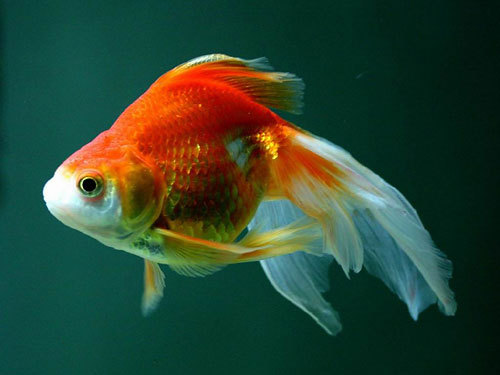

In [7]:
img = Image.open(fnames[50]); img

That's a nice looking image!

We'll be using this image with VGG16. Therefore, we need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [8]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [9]:
deproc = lambda x, s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

And finally we can grap an image

In [10]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

#### Broadcasting examples

Elementwise broadcasting

In [11]:
np.array([1, 2, 3]) - 2

array([-1,  0,  1])

Boardcasting takes the shortest tensor (ie. less dimensions) andprepends unit axis to the front. Below a two dimensional tensor vector) gets three unit axis to the front and becomes a 4-dimensional tensor. So making an object into higher dimensionality is easy by prepending unit axis. This is exactly what happens during broadcasting. The smallest dimensional tensor gets unit axis added. In the example above, the number two is turned into a vector of length 1. Then anything of length 1 gets dublicated to match the higher dimensional object.

In [12]:
np.array([2, 3]).reshape(1, 1, 1, 2)

array([[[[2, 3]]]])

In [13]:
np.array([2,3]).reshape(1, 1, 2, 1)

array([[[[2],
         [3]]]])

What broadcasting does can be showcased below, When subtracting `b` from `a`, behind the scenes it correponds to first appending unit axis untill we have a 4-tensor, like:
```
np.random.randn(2).reshape(1, 1, 1, 2)
```
Next this vector gets copied, such that it can be subtracte in each dimension, that is `5, 1, 3`.

In [14]:
# 4-dimensional tensor
a = np.random.randn(5, 1, 3, 2)

# Vector of length 2
b = np.random.randn(2)

print((a - b).shape)

(5, 1, 3, 2)


### Recreate input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layers, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (i.e. random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs. 

The interesting part is that now, instead of updating the parameters of the CNN, we update the pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both theano and tensorflow with the same code.

The CNN we'll use is VGG16, but with a twist. Previously we've always used Vgg with max pooling, and this was useful for image classification. It's not as useful in this case however, because max pooling loses information about the original input area. Instead we will use average pooling, as this does not throw away as much information.

In [15]:
model = Vgg(include_top = False).model

Inspect the model

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, None, None, 64)    1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, None, None, 64)    36928     
_________________________________________________________________
block_1_avgpool (AveragePool (None, None, None, 64)    0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, None, None, 128)   73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, None, None, 128)   147584    
_________________________________________________________________
block_2_avgpool (AveragePool (None, None, None, 128)   0         
__________

Here we're grabbing the activations from near the end of the convolutional model).

In [17]:
layer = model.get_layer('block_5_conv_0').output

And let's calculate the target activations for this layer:

In [18]:
# Create new model with old models input and the defined conv layers as output.
# We can then calculate the conv layer output below using predict.
layer_model = Model(model.input, layer)

# Wrap it as a TensorFlow symbolic variable in order to broadcast it to the GPU
# and use it in a computational Graph.
targ = K.variable(layer_model.predict(img_arr))

Inspect model

In [19]:
layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, None, None, 64)    1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, None, None, 64)    36928     
_________________________________________________________________
block_1_avgpool (AveragePool (None, None, None, 64)    0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, None, None, 128)   73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, None, None, 128)   147584    
_________________________________________________________________
block_2_avgpool (AveragePool (None, None, None, 128)   0         
__________

In our implementation, we need to define an object that will allow us to separately access the loss function and gradients of a function, since that is what scikit-learn's optimizers require. This evaluator object means that we can now solve functions written in keras using Scipy's deterministic optimisers.

In [20]:
class Evaluator(object):
    def __init__(self, f, shp): 
        self.f = f
        self.shp = shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [21]:
# The loss function is the mean squared error between the layer output fed the 
# trainable image input and the target calcualted above, given by feeding our 
# targetimage into the conv layer. The Keras implementation has an axis = -1
# in the mean, which returns an array, which seems like a bug. Hense the custom
# implementation.
loss = K.mean(K.square(layer - targ))

# Calculate the gradients of the loss given the model inputs, as it is the model
# input we want to change using a given optimiser
grads = K.gradients(loss, model.input)

# Calculate updates inputting the trainable model input and outputting the loss
# and the gradients as a joined list
fn = K.function([model.input], [loss] + grads)


evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_l_bfgs_b` funtionc, which is a limited memory implementation of the bfgs solver. 

In [22]:
def solve_image(eval_obj, niter, x, name):
    
    for i in range(niter):
        
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss,
                                         x.flatten(),
                                         fprime = eval_obj.grads,
                                         maxfun = 20)
        
        x = np.clip(x, -127, 127)
        
        print('Current loss value:', min_val)
        imsave(results_path + '/' + name + '_res_at_iteration_' + str(i) + '.png',
               deproc(x.copy(), shp)[0])
        
    return x

Next we need to generate a random image to use as starting point.

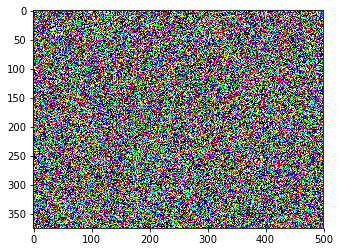

In [23]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 100
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [24]:
iterations = 10

In [25]:
x = solve_image(evaluator, iterations, x, name = 'recreate-input/conv5')

Current loss value: 99.0901489258
Current loss value: 32.8834724426
Current loss value: 19.4498538971
Current loss value: 14.0721158981
Current loss value: 11.1731309891
Current loss value: 9.37638378143
Current loss value: 8.12428855896
Current loss value: 7.29091739655
Current loss value: 6.55841732025
Current loss value: 5.91354560852


Our result by comparing output at conv 1 of last block (5) is fairly amorphous, but still easily recognizable as a fish. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing, such as an eye or scales.

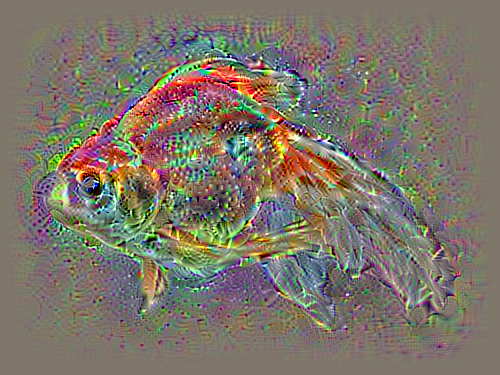

In [40]:
Image.open(results_path + 'recreate-input/conv5_res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of conv 1 of 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

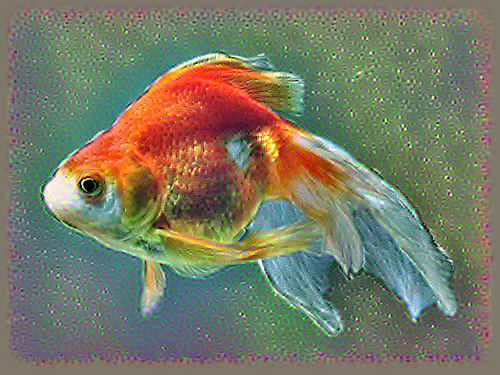

In [41]:
Image.open(results_path + 'recreate-input/conv4_res_at_iteration_9.png')

In [42]:
from IPython.display import HTML
from matplotlib import animation, rc

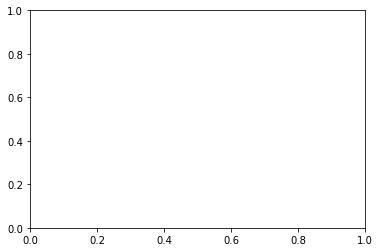

In [43]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(results_path + 'recreate-input/conv5_res_at_iteration_' + str(i) + '.png'))

The optimizer first focuses on the important details of the bird, before trying to match the background.

In [44]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

### Recreate style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By "style", we mean the color palette and texture of an image. Unlike recreating based on content, with style we are not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of "style".

Here are some examples of images we can extract style from.

In [45]:
def plot_arr(arr): plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

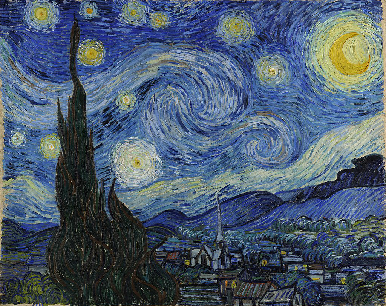

In [171]:
style = Image.open('data/styles/starry-night.jpg')
style = style.resize(np.divide(style.size, 2.65).astype('int32')); style

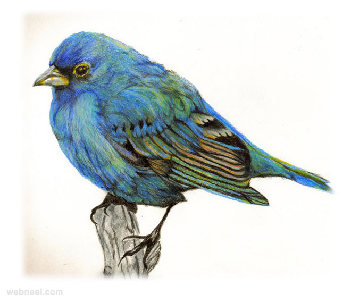

In [125]:
style = Image.open('data/styles/bird.jpg')
style = style.resize(np.divide(style.size, 1.88).astype('int32')); style

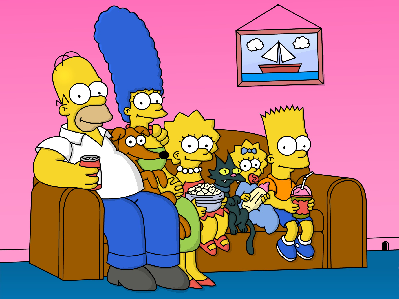

In [82]:
style = Image.open('data/styles/simpsons.jpg')
style = style.resize(np.divide(style.size, 5.54).astype('int32')); style

We're going to repeat the same approach as before, but with some differences.

In [172]:
style_arr = preproc(np.expand_dims(style,0)[:,:,:,:3])
shp = style_arr.shape

In [127]:
model = Vgg(include_top = False, input_shape = shp[1:]).model
outputs = {l.name: l.output for l in model.layers}

Inspect the outputs

In [128]:
outputs

{'block_1_avgpool': <tf.Tensor 'block_1_avgpool_3/AvgPool:0' shape=(?, 149, 173, 64) dtype=float32>,
 'block_1_conv_0': <tf.Tensor 'block_1_conv_0_3/Relu:0' shape=(?, 300, 349, 64) dtype=float32>,
 'block_1_conv_1': <tf.Tensor 'block_1_conv_1_3/Relu:0' shape=(?, 298, 347, 64) dtype=float32>,
 'block_2_avgpool': <tf.Tensor 'block_2_avgpool_3/AvgPool:0' shape=(?, 72, 84, 128) dtype=float32>,
 'block_2_conv_0': <tf.Tensor 'block_2_conv_0_3/Relu:0' shape=(?, 147, 171, 128) dtype=float32>,
 'block_2_conv_1': <tf.Tensor 'block_2_conv_1_3/Relu:0' shape=(?, 145, 169, 128) dtype=float32>,
 'block_3_avgpool': <tf.Tensor 'block_3_avgpool_3/AvgPool:0' shape=(?, 33, 39, 256) dtype=float32>,
 'block_3_conv_0': <tf.Tensor 'block_3_conv_0_3/Relu:0' shape=(?, 70, 82, 256) dtype=float32>,
 'block_3_conv_1': <tf.Tensor 'block_3_conv_1_3/Relu:0' shape=(?, 68, 80, 256) dtype=float32>,
 'block_3_conv_2': <tf.Tensor 'block_3_conv_2_3/Relu:0' shape=(?, 66, 78, 256) dtype=float32>,
 'block_4_avgpool': <tf.Tens

One thing to notice is that we're actually going to be calculating the loss function multiple layers, rather than just one. (Note however that there's no reason you couldn't try using multiple layers in your content loss function, if you wanted to try that).

In [129]:
layers = [outputs['block_{}_conv_0'.format(o)] for o in range(1,3)]

So we now have a list of targets for the given style

In [130]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

The key difference is our choice of loss function. Whereas before we were calculating mse of the raw convolutional outputs, here we transform them into the "gramian matrix" of their channels (that is, the product of a matrix and its transpose) before taking their mse. It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [131]:
def gram_matrix(x):
    
    # We want each row to be a channel, and the columns to be flattened x, y 
    # locations. So `K.permute_dimensions(x, (2, 0, 1))` rearranges in challens,
    # x, y and 'K.batch_flatten' flattens the latter two dimensions.
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

Note that we again calculate our own loss.

In [132]:
def style_loss(x, targ): return K.mean(K.square(gram_matrix(x) - gram_matrix(targ)))

Define loss, grads, funktion and evaluator

In [133]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We then solve as we did before.

In [134]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = filters.gaussian_filter(x, [0,2,2,0])

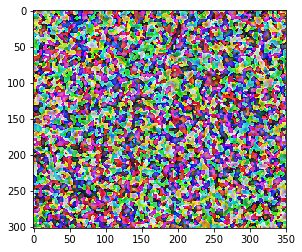

In [135]:
plt.imshow(x[0]);

In [136]:
iterations = 10
x = rand_img(shp)

In [137]:
x = solve_image(evaluator, iterations, x, name = 'style-recreation/bird')

Current loss value: 28148.5058594
Current loss value: 6838.11181641
Current loss value: 1038.25463867
Current loss value: 343.425445557
Current loss value: 185.535842896
Current loss value: 110.720855713
Current loss value: 72.3721160889
Current loss value: 49.5724067688
Current loss value: 35.5517845154
Current loss value: 28.3135128021


Our results are stunning. By transforming the convolutional outputs to the gramian, we are somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure or meaning. Why is that? Nobody knows :D

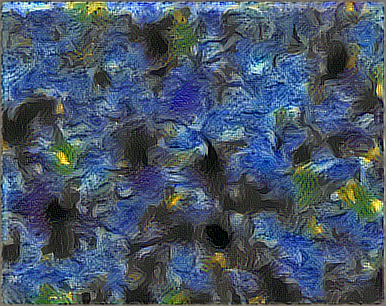

In [138]:
Image.open('results/style-recreation/starry_night_res_at_iteration_9.png')

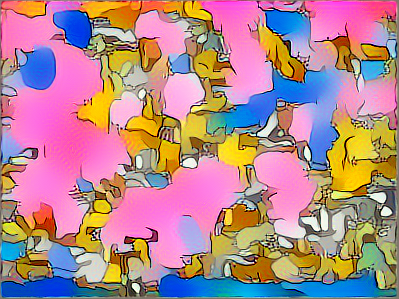

In [139]:
Image.open('results/style-recreation/simpsons_res_at_iteration_9.png')

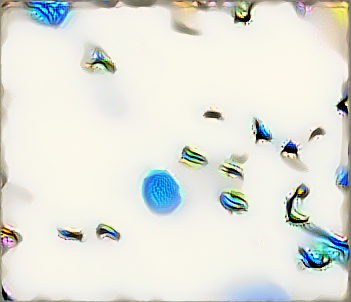

In [140]:
Image.open('results/style-recreation/bird_res_at_iteration_9.png')

### Style transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

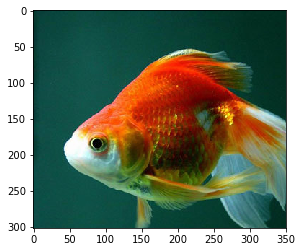

In [142]:
w,h = style.size
src = img_arr[:,:h,:w]
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image "looks like" the same subject, even if it doesn't have the same details.

In [143]:
# Use second level convolutional layers from all blocks for style
style_layers = [outputs['block_{}_conv_1'.format(o)] for o in range(1, 6)]

# Use second level convolutional layer from 4th block for content
content_name = 'block_4_conv_1'
content_layer = outputs[content_name]

Create the style model taking the vgg input and outputting the style layers. Create a list of the style targets.

In [144]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

Inspect style model

In [145]:
style_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 302, 351, 3)       0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, 300, 349, 64)      1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, 298, 347, 64)      36928     
_________________________________________________________________
block_1_avgpool (AveragePool (None, 149, 173, 64)      0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, 147, 171, 128)     73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, 145, 169, 128)     147584    
_________________________________________________________________
block_2_avgpool (AveragePool (None, 72, 84, 128)       0         
__________

Examine style outputs - Note that the single style model returns 5 style layer outputs.

In [146]:
style_model.outputs

[<tf.Tensor 'block_1_conv_1_3/Relu:0' shape=(?, 298, 347, 64) dtype=float32>,
 <tf.Tensor 'block_2_conv_1_3/Relu:0' shape=(?, 145, 169, 128) dtype=float32>,
 <tf.Tensor 'block_3_conv_1_3/Relu:0' shape=(?, 68, 80, 256) dtype=float32>,
 <tf.Tensor 'block_4_conv_1_3/Relu:0' shape=(?, 29, 35, 512) dtype=float32>,
 <tf.Tensor 'block_5_conv_1_3/Relu:0' shape=(?, 9, 12, 512) dtype=float32>]

Create the content model taking the vgg input and outputting the content layer. Define the content target.

In [147]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Inspect model

In [164]:
content_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 302, 351, 3)       0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, 300, 349, 64)      1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, 298, 347, 64)      36928     
_________________________________________________________________
block_1_avgpool (AveragePool (None, 149, 173, 64)      0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, 147, 171, 128)     73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, 145, 169, 128)     147584    
_________________________________________________________________
block_2_avgpool (AveragePool (None, 72, 84, 128)       0         
__________

Examine content output - Note that the single style model returns 1 content layer output.

In [166]:
content_model.output

<tf.Tensor 'block_4_conv_1_3/Relu:0' shape=(?, 29, 35, 512) dtype=float32>

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous to functions, this function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we are training. 

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we increase that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it is too small than the image will not have enough style.

In [148]:
style_wgts = [0.05, 0.2, 0.2, 0.25, 0.3]

In [167]:
# The combined style loss
loss = sum(style_loss(l1[0], l2[0]) * w for l1, l2, w in zip(style_layers, style_targs, style_wgts))

# Add the content loss
loss += K.mean(K.square(content_layer - content_targ)) / 5.

# Gradients of the loss w.r.t. the random input
grads = K.gradients(loss, model.input)

# Style transfer function
transfer_fn = K.function([model.input], [loss] + grads)

Initialise evaluator

In [168]:
evaluator = Evaluator(transfer_fn, shp)

Train model

In [169]:
iterations = 10
x = rand_img(shp)

x = solve_image(evaluator, iterations, x, name = 'style-transfer/fish-bird')

Current loss value: 39557.328125
Current loss value: 17990.2285156
Current loss value: 6276.35839844
Current loss value: 3733.17504883
Current loss value: 2899.75073242
Current loss value: 2539.47949219
Current loss value: 2323.47070313
Current loss value: 2180.59228516
Current loss value: 2064.2746582
Current loss value: 1956.20556641


These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

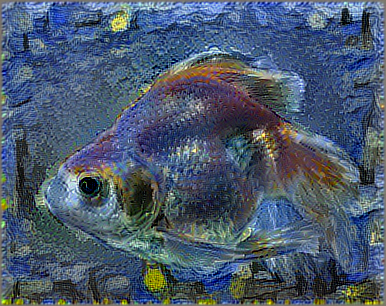

In [112]:
Image.open('results/style-transfer/fish-starry-night_res_at_iteration_9.png')

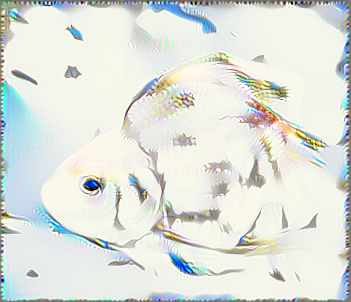

In [170]:
Image.open('results/style-transfer/fish-bird_res_at_iteration_9.png')

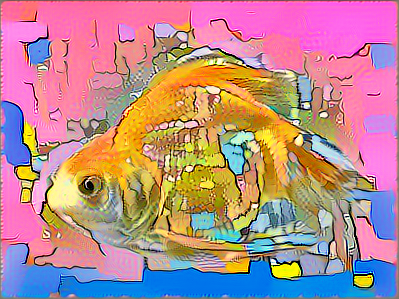

In [110]:
Image.open('results/style-transfer/fish-simpsons_res_at_iteration_9.png')

There are lots of interesting additional things you could try, such as the ideas shown here: https://github.com/titu1994/Neural-Style-Transfer .

## Use content loss to create a super-resolution network

So far we've demonstrated how to achieve succesful results in style transfer. However, there is an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible method for any sort of real-time application. Fortunately we can adress this issue by using a fully convolutional network (FCN), and in particular we'll look at this implementation for Super resolution. We are following the approach in [this paper](https://arxiv.org/abs/1603.08155).

In [11]:
# Note that we slice in order to turn the bolz array into a numpy ndarray
arr_lr = bcolz.open(data_d_path + 'trn_resized_72.bc')[:]
arr_hr = bcolz.open(data_d_path + 'trn_resized_288.bc')[:]

Use TQDM for progress bars.

In [12]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner = True)]}

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in [Resnet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 convolutional layers that is added to the initial block input. We also have a de-convolutional layer (also known as a "transposed convolution" or "fractionally strided convolution"), whose purpose is to learn to "undo" the convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [13]:
# Convolution block
def conv_block(x, filters, kernel_size, strides = (2, 2), padding = 'same',
               activation = True):
    
    x = Conv2D(filters,
               kernel_size = kernel_size,
               strides = strides, 
               padding = padding)(x)
    x = BatchNormalization()(x)
    
    return Activation('relu')(x) if activation else x

# Residual block
def res_block(inp, num_filters = 64):
    
    x = conv_block(inp, num_filters, (3, 3), (1, 1))
    x = conv_block(x, num_filters, (3, 3), (1, 1), activation = False)
    
    return add([x, inp])

# Deconvolutional block
def deconv_block(x, filters, kernel_size, shape, strides = (2, 2)):
    
    x = Conv2DTranspose(filters,
                        kernel_size = kernel_size,
                        strides = strides,
                        padding = 'same',
                        output_shape = (None, ) + shape)(x)
    x = BatchNormalization()(x)
    
    return Activation('relu')(x)

# Upsample block
def up_block(x, filters, kernel_size):
    
    x = UpSampling2D()(x)
    x = Conv2D(filters,
               kernel_size = kernel_size,
               padding = 'same')(x)
    x = BatchNormalization()(x)
    
    return Activation('relu')(x)

This model here is using the previously defined blocks to encode a low resolution image and then upsample it to match the same image in high resolution.

In [176]:
# Input layer
inp = Input(arr_lr.shape[1:])

# Convolution block
x = conv_block(inp, 64, (9, 9), (1, 1))

# 4 residual blocks
for i in range(4): x = res_block(x)

# Upsampling block/deconvolution block depending on choice
x = up_block(x, 64, (3, 3))
x = up_block(x, 64, (3, 3))

# Final convolution block
x = Conv2D(3, (9, 9), activation = 'tanh', padding = 'same')(x)

# Transform the output such that the output image has pixel range [0, 255]
outp = Lambda(lambda x: (x + 1) * 127.5)(x)

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image. 

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convolutional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we are able to train a network that can upsample an image and recreate the higher resolution details.

In [178]:
# Shape of up scaled output
out_shape = arr_hr.shape[1:]

# Define input to VGG, it being the shape of the output. Remember, we
# only want to use VGG as a loss function.
vgg_inp = Input(out_shape)

# Note we now use the traditional VGG16 with max pooling
vgg = Vgg(include_top = False,
          input_tensor = Lambda(preproc)(vgg_inp),
          pooling = 'max').model

# Inspect
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, 286, 286, 64)      1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, 284, 284, 64)      36928     
_________________________________________________________________
block_1_maxpool (MaxPooling2 (None, 142, 142, 64)      0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, 140, 140, 128)     73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, 138, 138, 128)     147584    
__________

Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, we set the Vgg layers to not be trainable.

In [179]:
for l in vgg.layers: l.trainable = False

An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer). 

In [182]:
def get_outp(m, ln): return m.get_layer('block_' + str(ln) + '_conv_0').output

vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1, 2, 3]])

# In Keras' functional API, any layer (and a model is a layer), can be treated
# as if it was a function. So we can take any model and pass it a tensor, and
# Keras will join the model together.
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

To get some intuition. Inspect each model in terms of layers, input and output

For the base content model

In [183]:
vgg_content.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, 286, 286, 64)      1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, 284, 284, 64)      36928     
_________________________________________________________________
block_1_maxpool (MaxPooling2 (None, 142, 142, 64)      0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, 140, 140, 128)     73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, 138, 138, 128)     147584    
__________

In [184]:
print(vgg_content.inputs)
print(vgg_content.outputs)

[<tf.Tensor 'input_7:0' shape=(?, 288, 288, 3) dtype=float32>]
[<tf.Tensor 'block_1_conv_0_4/Relu:0' shape=(?, 286, 286, 64) dtype=float32>, <tf.Tensor 'block_2_conv_0_4/Relu:0' shape=(?, 140, 140, 128) dtype=float32>, <tf.Tensor 'block_3_conv_0_4/Relu:0' shape=(?, 67, 67, 256) dtype=float32>]


`vgg1` and `vgg2` returns the same output vector. But it will be calculated by different inputs. So for `vgg1` the high res input image is passed as input to the `vgg_content` model. For `vgg2` the output from the super resolution model is passed as input to the `vgg_content` model.

In [188]:
print(vgg1, vgg2)

[<tf.Tensor 'model_14/block_1_conv_0/Relu:0' shape=(?, 286, 286, 64) dtype=float32>, <tf.Tensor 'model_14/block_2_conv_0/Relu:0' shape=(?, 140, 140, 128) dtype=float32>, <tf.Tensor 'model_14/block_3_conv_0/Relu:0' shape=(?, 67, 67, 256) dtype=float32>] [<tf.Tensor 'model_14_1/block_1_conv_0/Relu:0' shape=(?, 286, 286, 64) dtype=float32>, <tf.Tensor 'model_14_1/block_2_conv_0/Relu:0' shape=(?, 140, 140, 128) dtype=float32>, <tf.Tensor 'model_14_1/block_3_conv_0/Relu:0' shape=(?, 67, 67, 256) dtype=float32>]


Define the mean sum of squared

In [189]:
def mean_sqr_b(diff): 
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff ** 2, dims)), 0)

Define function to weight each layer of the VGG model

In [190]:
w = [0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n = len(w)
    for i in range(n): res += mean_sqr_b(x[i] - x[i + n]) * w[i]
    return res

We then define the final model, which will combine the two models, `vgg1` and `vgg2`. This final model will take the same inputs as `vgg1` and `vgg2` and output a single loss value from the trasformation (`content_fn`) of the combined outputs. This is like adding a final layers on top of the output of `vgg1` and `vgg2`.

In [195]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1 + vgg2))

# Taget is just 0 for each pixel value
targ = np.zeros((arr_hr.shape[0], 1))

Visualise model

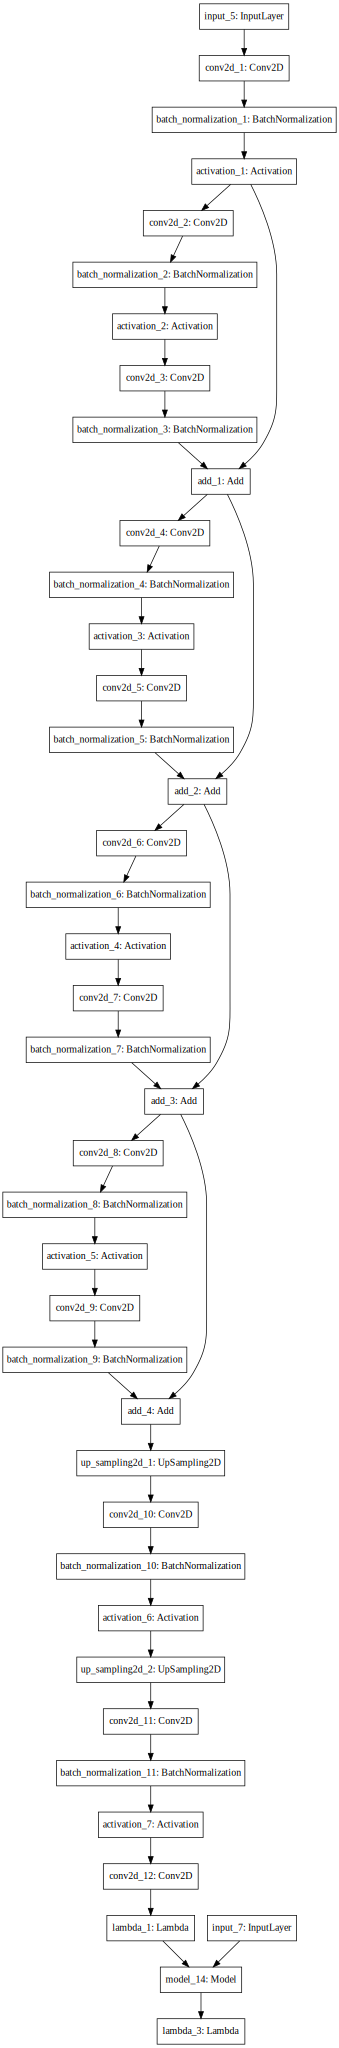

In [192]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot 

SVG(model_to_dot(m_sr).create(prog = 'dot', format = 'svg'))

And inspect the model and consider inputs and outputs

In [193]:
m_sr.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 72, 72, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 72, 72, 64)    15616       input_5[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 72, 72, 64)    256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 72, 72, 64)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

input_7 (InputLayer)             (None, 288, 288, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 288, 288, 3)   0           conv2d_12[0][0]                  
____________________________________________________________________________________________________
model_14 (Model)                 [(None, 286, 286, 64) 555328      input_7[0][0]                    
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
lambda_3 (Lambda)                (1, None)             0           model_14[1][0]                   
                                                                   model_14[1][1]                   
                                                                   model_14[1][2]          

Note that we output the loss function values, which we then just want to get as close to zero as possible.

In [194]:
print(m_sr.inputs)
print(m_sr.outputs)

[<tf.Tensor 'input_5:0' shape=(?, 72, 72, 3) dtype=float32>, <tf.Tensor 'input_7:0' shape=(?, 288, 288, 3) dtype=float32>]
[<tf.Tensor 'lambda_3/add_2:0' shape=(1, ?) dtype=float32>]


Finally we compile this chain of models and we can pass it the original low resolution image as well as the high resolution to train on. We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.

In [196]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **parms)

We use learning rate annealing to get a better fit.

In [197]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **parms)

As we are only considering super resolution, we are only interested in the trained part of the model, which does the actual upsampling.

In [198]:
top_model = Model(inp, outp)

We can then do a prediction

In [199]:
p = top_model.predict(arr_lr[10:11])

After training for some time, we get some very impressive results! Look at these two images, we can see that the predicted higher resolution image has filled in a lot of detail, including the shadows under the greens and the texture of the food.

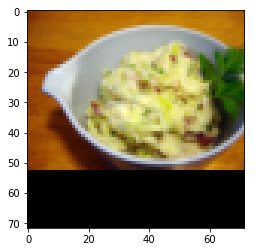

In [200]:
plt.imshow(arr_lr[10].astype('uint8'));

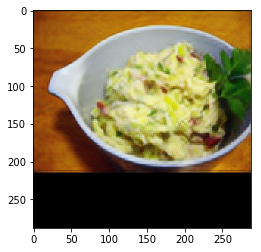

In [201]:
plt.imshow(p[0].astype('uint8'));

Lets save the weights of this model. as it is the important part.

In [202]:
top_model.save_weights('results/' + 'sr_final.h5')

In [203]:
top_model.load_weights('results/' + 'sr_final.h5')

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can created the desired image and is a scalable implementation.

Further, the model is totally independent of image size at training time.

Note that we haven't used a test set here, so we don't know if the above result is due to over-fitting. As part of your homework, you should create a test set, and try to train a model that gets the best result you can on the test set.

## Fast style transfer

The original paper showing the above approach to super resolution also used this approach to create a much faster style transfer system (for a specific style). Take a look at [the paper](https://arxiv.org/abs/1603.08155) and the very helpful [supplementary material](http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf). Your mission, should you choose to accept it, it to modify the super resolution example above to do fast style transfer based on this paper. 

### Reflection padding

The supplementary material mentions that that found reflection padding helpful - we have implemented this as a keras layer for you. All the other layers and blocks are already defined above.

(This is also a nice simple example of a custom later that you can refer to when creating your own custom layers in the future.)

In [14]:
class ReflectionPadding2D(Layer):
    
    def __init__(self, padding = (1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim = 4)]
        super().__init__(**kwargs)
        
    def compute_output_shape(self, s):
        width = s[1] + 2 * self.padding[0] if s[1] is not None else None
        height = s[2] + 2 * self.padding[1] if s[2] is not None else None
        
        return (s[0], width, height, s[3])

    def call(self, x, mask = None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0] ], 'REFLECT')

Testing the reflection padding layer:

In [15]:
inp = Input((None, None, 3))
ref_model = Model(inp, ReflectionPadding2D((40, 40))(inp))
ref_model.compile('adam', 'mse')

In [16]:
p = ref_model.predict(arr_hr[0:11])

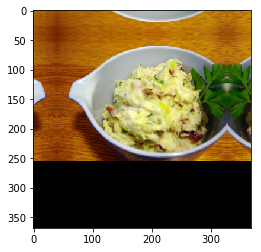

In [17]:
plt.imshow(p[10].astype('uint8'));

### Main algorithm

This approach is exactly the same as super resolution, except now the loss includes the style loss.

Get the shape of the high resolution input images, that we will train on.

In [18]:
shp = arr_hr.shape[1:]
shp_test = (256, 256, 3)
print(shp, shp_test)

(288, 288, 3) (256, 256, 3)


Read style image and resize to the same dimension as out training images.

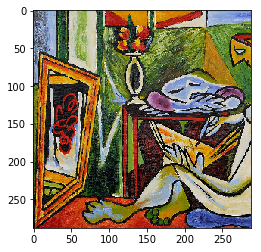

In [19]:
style = Image.open('data/styles/picasso-the-muse.jpg')
#style = Image.open('data/styles/van-gogh-self-portrait.jpg')

if style.height <= style.width:
    img_size = style.height
else:
    img_size = style.width
resize_factor = np.divide(style.size,
                          np.floor(img_size / shp[0] \
                                    * 10) / 10.).astype('int32')

# Resize image based on height
style = style.resize(resize_factor)
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

We will reuse the blocks defined in the super resolution part above. However, we will replace the residual blocks with a res crop block, where we eliminate the zero padding of the inputs. This helps eliminate artifacts around the border of the generated image.

In [20]:
def res_crop_block(ip, nf = 64):
    x = conv_block(ip, nf, 3, (1, 1), 'valid')
    x = conv_block(x,  nf, 3, (1, 1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return add([x, ip])

We define a new super resolution network using the residual crop blocks.

In [21]:
inp = Input((None, None, 3))
x = ReflectionPadding2D((40, 40))(inp)
x = conv_block(x, 32, 9, (1, 1))
x = conv_block(x, 64, 3)
x = conv_block(x, 128, 3)
for i in range(5): x = res_crop_block(x, 128)
x = up_block(x, 64, 3)
x = up_block(x, 32, 3)
x = Conv2D(3, kernel_size = (9, 9), activation = 'tanh', padding = 'same')(x)
outp = Lambda(lambda x: (x + 1) * 127.5)(x)

We then define the vgg model, which we will use to extract the style and content features.

In [22]:
# Input (raw high res training image)
vgg_inp = Input(shp)

# Define VGG model
vgg = Vgg(include_top = False,
          input_tensor = Lambda(preproc)(vgg_inp),
          pooling = 'max').model

# Set all VGG layers to be non-trainable
for l in vgg.layers: l.trainable = False

Inspect model

In [23]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, 286, 286, 64)      1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, 284, 284, 64)      36928     
_________________________________________________________________
block_1_maxpool (MaxPooling2 (None, 142, 142, 64)      0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, 140, 140, 128)     73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, 138, 138, 128)     147584    
__________

Consider current input and output, just standard VGG in current configuration.

In [24]:
print(vgg.input)
print(vgg.output)

Tensor("input_3:0", shape=(?, 288, 288, 3), dtype=float32)
Tensor("block_5_maxpool/MaxPool:0", shape=(?, 3, 3, 512), dtype=float32)


We then define the content, and instead of considering the content from a single layer, we consider the content output of 4 layers.

In [26]:
def get_outp(model, layer): 
    return model.get_layer('block_' + str(layer[0]) + '_conv_' \
        + str(layer[1])).output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [(2, 1), (3, 1), (4, 2), (5, 2)]])

Inspect the model, still standard vgg type model

In [27]:
vgg_content.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block_1_conv_0 (Conv2D)      (None, 286, 286, 64)      1792      
_________________________________________________________________
block_1_conv_1 (Conv2D)      (None, 284, 284, 64)      36928     
_________________________________________________________________
block_1_maxpool (MaxPooling2 (None, 142, 142, 64)      0         
_________________________________________________________________
block_2_conv_0 (Conv2D)      (None, 140, 140, 128)     73856     
_________________________________________________________________
block_2_conv_1 (Conv2D)      (None, 138, 138, 128)     147584    
__________

But in the new content specification of the vgg model we output from 4 layers.

In [28]:
print(vgg_content.inputs)
print(vgg_content.outputs)

[<tf.Tensor 'input_3:0' shape=(?, 288, 288, 3) dtype=float32>]
[<tf.Tensor 'block_2_conv_1/Relu:0' shape=(?, 138, 138, 128) dtype=float32>, <tf.Tensor 'block_3_conv_1/Relu:0' shape=(?, 65, 65, 256) dtype=float32>, <tf.Tensor 'block_4_conv_2/Relu:0' shape=(?, 25, 25, 512) dtype=float32>, <tf.Tensor 'block_5_conv_2/Relu:0' shape=(?, 6, 6, 512) dtype=float32>]


Here we alter the super resolution approach by adding style outputs. Note that we can again just predict the style targets in order to save computation time.

In [29]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style, 0))]

The shape of the style targets matches the activations of each conv layer of the vgg model.

In [30]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 138, 138, 128]),
 array([  1,  65,  65, 256]),
 array([  1,  25,  25, 512]),
 array([  1,   6,   6, 512])]

As in the pure super resolution model we then define two vgg models. One where the input is just that training image and the other where the input is the output of the super resolution model.

In [31]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

Again we see that both models have the same output, but each is calculated from different inputs.

In [32]:
print(vgg1, vgg2)

[<tf.Tensor 'model_2/block_2_conv_1/Relu:0' shape=(?, 138, 138, 128) dtype=float32>, <tf.Tensor 'model_2/block_3_conv_1/Relu:0' shape=(?, 65, 65, 256) dtype=float32>, <tf.Tensor 'model_2/block_4_conv_2/Relu:0' shape=(?, 25, 25, 512) dtype=float32>, <tf.Tensor 'model_2/block_5_conv_2/Relu:0' shape=(?, 6, 6, 512) dtype=float32>] [<tf.Tensor 'model_2_1/block_2_conv_1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>, <tf.Tensor 'model_2_1/block_3_conv_1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>, <tf.Tensor 'model_2_1/block_4_conv_2/Relu:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'model_2_1/block_5_conv_2/Relu:0' shape=(?, ?, ?, 512) dtype=float32>]


We define the total variation loss. This is a loss implementation we add to smothen we output image - that is avoiding local artifacts. This is basically a regularization layer, that we add on top of the super resolution model.

In [33]:
def total_variation_loss(x):

    a = K.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])

    b = K.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    
    return K.sum(K.pow(a + b, 1.25))

Define a gram matrix function, where the gram matrix is taken in batches.

In [34]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

def mean_sqr_b(diff):
    '''
        Calculate the mean squared error based on a given input difference.

        Args:
            diff (tensor): Two 4-tensors subtracted from each other

        Returns: The MSE
    '''
    # Get tensor dimensions
    dims = list(range(1, K.ndim(diff)))
    
    # Calculate MSE
    return K.expand_dims(K.sqrt(K.mean(diff ** 2, dims)), 0)

Finally define the combined loss function, combining style loss, content loss and total variation loss.

In [35]:
w = [0.025, 0.8, 0.15, 0.025]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        
        # Style loss
        loss += mean_sqr_b(gram_matrix_b(x[i + n]) - gram_matrix_b(style_targs[i]))
        
        # Content loss
        loss += mean_sqr_b(x[i] - x[i + n]) * w[i]
        
    # Total variation loss
    loss += total_variation_loss(x[n * 2]) * 1e-7
    return loss


We then define the style model. This is basically two models returning a single output loss. One model is the unaltered VGG fed our training image. The other is the VGG fed the output of the super resolution network. The model output is the loss calculated from 1) the style loss (the MSE of the gram matrix of the content conv and the style conv), the content loss (The MSE of the super resolution VGG conv output and the VGG conv output) and the total variation loss (calculated from the super resolution output).

In [38]:
# Loss function
loss = Lambda(tot_loss)(vgg1 + vgg2 + [outp])

# Style model.
m_style = Model([inp, vgg_inp], loss)

# Our target is 0, as we have specified the loss function directly.
targ = np.zeros((arr_hr.shape[0], 1))

Vizualise the model layers.

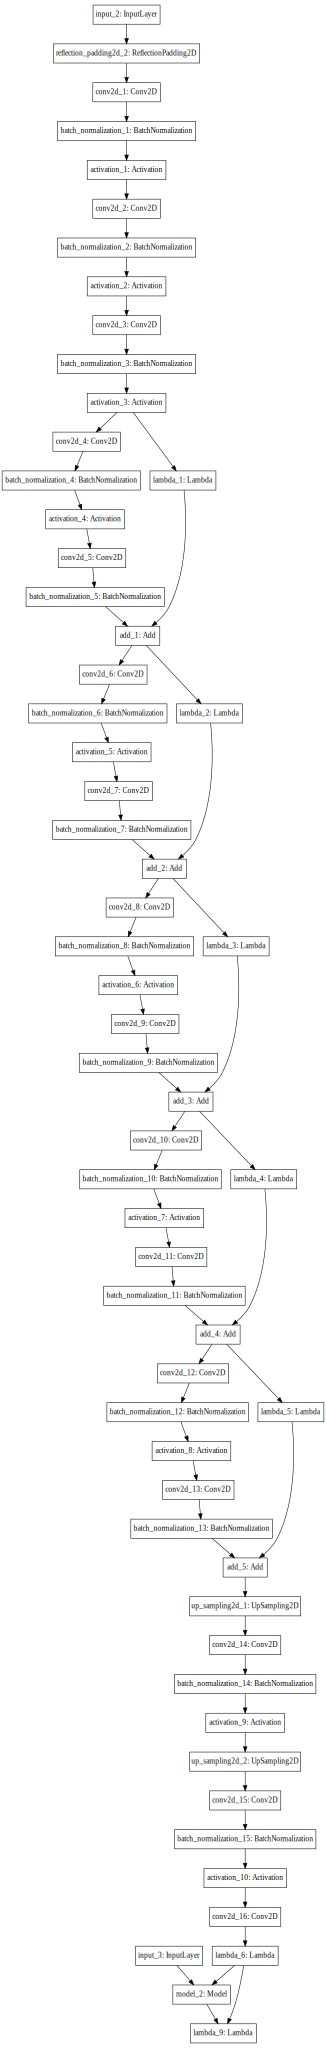

In [39]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot 

SVG(model_to_dot(m_style).create(prog = 'dot', format = 'svg'))

We can then compile and train the model.

In [40]:
m_style.compile('adam', 'mae')
K.set_value(m_style.optimizer.lr, 1e-3)
m_style.fit([arr_hr, arr_hr], targ, 8, 2, **parms)

KeyboardInterrupt: 

272/|/[loss: 3074.338] :   1%|| 272/19439 [00:39<23:05, 13.83it/s]                            

And lower the learning rate and train some more.

In [ ]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 8, 1, **parms)

Our generating model, is just the super resolution model. The VGG part is just to calculate loss - It did not have trainable parameters.

In [47]:
top_model = Model(inp, outp)

Now we can pass any image through this CNN and it will produce it in the style desired!

In [278]:
def display_image_in_actual_size(p):

    dpi = 200
    im_data = np.round(p[0]).astype('uint8')
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

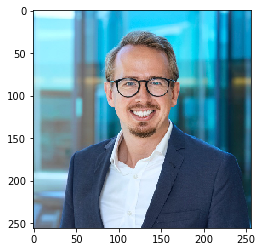

In [48]:
test_img = Image.open('test/akll-color-big.jpg')
#style = Image.open('data/styles/van-gogh-self-portrait.jpg')

if test_img.height <= test_img.width:
    img_size = test_img.height
else:
    img_size = test_img.width
resize_factor = np.divide(test_img.size,
                          np.floor(img_size / shp_test[0] \
                                    * 10) / 10.).astype('int32')

# Resize image based on height
test_img = test_img.resize(resize_factor)
test_img = np.array(test_img)[:shp_test[0], :shp_test[1], :shp_test[2]]
plt.imshow(test_img);

In [280]:
test_img_style.shape

(1, 256, 256, 3)

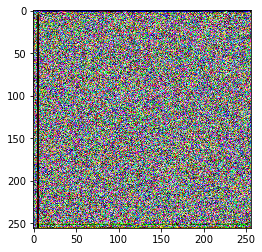

In [49]:
test_img_style = top_model.predict(np.expand_dims(np.array(test_img), 0))
plt.imshow(test_img_style[0]);

In [ ]:
deloitte = Image.open('test/deloitte-huset.jpg')#.astype('int32')
deloitte = deloitte.resize(np.divide(deloitte.size,2.65).astype('int32'))
#deloitte = np.expand_dims(np.array(deloitte), 0)
display_image_in_actual_size(deloitte)

In [ ]:
deloitte_style = top_model.predict(np.expand_dims(np.array(deloitte), 0))
display_image_in_actual_size(deloitte_style)

In [ ]:
nyhavn = Image.open('test/nyhavn.jpg')#.astype('int32')
nyhavn = nyhavn.resize(np.divide(deloitte.size, 1).astype('int32'))
#nyhavn = np.asarray(nyhavn, dtype = 'float32')
plt.imshow(nyhavn)

In [ ]:
nyhavn_style = top_model.predict(np.expand_dims(np.array(nyhavn), 0))
display_image_in_actual_size(nyhavn_style)

In [ ]:
top_model.save_weights('results/style_final.h5')

In [ ]:
top_model.load_weights('results/style_final.h5')

## Next steps

Here's some ideas for things to try:
- https://github.com/junyanz/iGAN
- https://arxiv.org/abs/1605.04603
- https://arxiv.org/abs/1606.05897
- http://cs231n.stanford.edu/reports2016/208_Report.pdf